In [3]:
from PIL import Image, ImageSequence
import numpy as np
image_tiff = Image.open("/home/marco/Base_Patrones/Celulas/datos_tarea2/segmentacion_referencia.tif")

images_ref = []
for i, page in enumerate(ImageSequence.Iterator(image_tiff)):
    images_ref.append(np.array(page))
    
image_tiff = Image.open("/home/marco/Base_Patrones/Celulas/datos_tarea2/raw.tif")

images_raw=[]
for i, page in enumerate(ImageSequence.Iterator(image_tiff)):
    images_raw.append(np.array(page))

In [48]:
import numpy as np
import cv2

def get_carec(Imagen):
    kernel = np.array([[1/9,1/9,1/9],
                    [1/9,1/9,1/9],
                    [1/9,1/9,1/9]
                       ], np.float32)
    promedio = cv2.filter2D(Imagen, -1, kernel)
    laplacian = cv2.Laplacian(Imagen,cv2.CV_64F)
    sobelx = cv2.Sobel(Imagen,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(Imagen,cv2.CV_64F,0,1,ksize=5)
    
    return promedio, laplacian, sobelx, sobely

def trans_class(imagen):
    new_img=[]
    for vec in imagen:
        im = np.where(vec==255,1,vec)
        new_img.append(im)
    return np.array(new_img)

In [5]:
promedio, laplacian, sobelx, sobely = get_carec(images_raw[40])

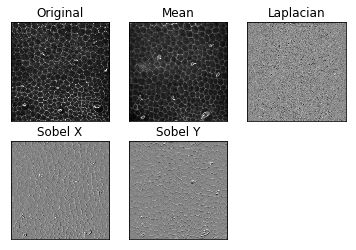

In [6]:
from matplotlib import pyplot as plt

plt.subplot(2,3,1),plt.imshow(images_raw[2],cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(promedio,cmap = 'gray')
plt.title('Mean'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,4),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,5),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

In [29]:
def constru_BD(images_ref,images_raw,index1,index2):
    ind_imag=index1
    fila_promedio = np.array([])
    fila_laplacian = np.array([])
    fila_sobelx = np.array([])
    fila_sobely = np.array([])
    fila_target = np.array([])
    for img in images_raw[index1:index2]:
            
            promedio, laplacian, sobelx, sobely = get_carec(img)
            target = trans_class(images_ref[ind_imag])
            fila_promedio=np.concatenate((fila_promedio,promedio.flatten()),axis=None)
            fila_laplacian=np.concatenate((fila_laplacian,laplacian.flatten()),axis=None)
            fila_sobelx=np.concatenate((fila_sobelx,sobelx.flatten()),axis=None)
            fila_sobely=np.concatenate((fila_sobely,sobely.flatten()),axis=None)
            fila_target=np.concatenate((fila_target,target.flatten()),axis=None)
            ind_imag=ind_imag+1
    matrix = []
    matrix.append(fila_promedio)
    matrix.append(fila_laplacian)
    matrix.append(fila_sobelx)
    matrix.append(fila_target)
    return np.array(matrix), fila_target


In [30]:
matrix, target = constru_BD(images_ref,images_raw,0,10)

In [31]:
matrix = np.transpose(matrix)
print(matrix.shape,target.shape)

(2621440, 4) (2621440,)


In [32]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,max_depth=10)


In [33]:
clf.fit(matrix,target) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [34]:
matrix1, target1 = constru_BD(images_ref,images_raw,50,51)
matrix2= np.transpose(matrix1)
print(matrix2.shape)

(262144, 4)


In [35]:
import warnings; warnings.simplefilter('ignore')
def evaluar_fores(matrix):
    resp = []
    for vec in matrix:
        resp.append(clf.predict(vec))
    return np.array(resp)


In [47]:
preic = evaluar_fores(matrix2)

KeyboardInterrupt: 

In [38]:
predic =[]
for x in preic:
    predic.append(x[0])

predic = np.array(predic)



In [43]:
def borde_marcador(imagen,predic):
    iindex=0
    resp=[]
    count =0
    for x in predic:
        if x[0] ==0:
            #count=count+1
            resp.append(230)
        else:
            resp.append(imagen[iindex])
        iindex=iindex+1
    return np.array(resp), count

In [44]:
resp,count = borde_marcador(images_raw[4].flatten(),preic)
resp = resp.reshape(512,512)
print(count)

0


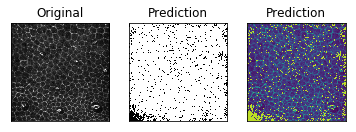

In [45]:
plt.subplot(1,3,1),plt.imshow(images_raw[4],cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(predic.reshape(512,512),cmap = 'gray')
plt.title('Prediction'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(resp)
plt.title('Prediction'), plt.xticks([]), plt.yticks([])
plt.show()

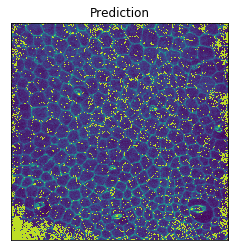

In [46]:
plt.imshow(resp)
plt.title('Prediction'), plt.xticks([]), plt.yticks([])
plt.show()

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7)


In [16]:
knn.fit(matrix,target) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [17]:
import warnings; warnings.simplefilter('ignore')
def evaluar_knn(matrix):
    resp = []
    for vec in matrix:
        resp.append(knn.predict(vec))
    return np.array(resp)

In [21]:
preic = evaluar_knn(matrix2)

In [37]:
predic =[]
for x in preic:
    predic.append(x[0])

predic = np.array(predic)



In [26]:
resp,count = borde_marcador(images_raw[4].flatten(),preic)
resp = resp.reshape(512,512)
print(count)

24170


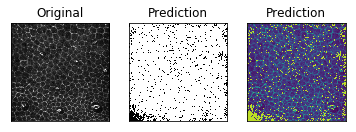

In [27]:
plt.subplot(1,3,1),plt.imshow(images_raw[4],cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(predic.reshape(512,512),cmap = 'gray')
plt.title('Prediction'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(resp)
plt.title('Prediction'), plt.xticks([]), plt.yticks([])
plt.show()

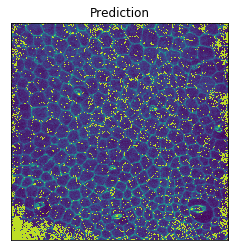

In [28]:
plt.imshow(resp)
plt.title('Prediction'), plt.xticks([]), plt.yticks([])
plt.show()